<a href="https://colab.research.google.com/github/savid97/Data_Science_Learning/blob/main/Covid_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Project 2: Viral prediction

Date: 2021.11.15

Solution author: © 2021 [Yusef Savid](https://www.linkedin.com/in/yusef-savid-651025149/) 

Template author: © 2021 [Mantas Lukoševičius](https://mantas.info/)

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

You should only eddit this notebook where it is allowed, comment on all of your improvements in markdown cells and in your presentation.

Here we analyze open COVID-19 data from https://ourworldindata.org/coronavirus and try to predict new cases in the world for one week into the future.

## Load the data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Download the data to cache locally. Do this once (a day), and comment out again, not to DoS the server. (adopted from https://stackoverflow.com/a/35997720).

In [ ]:
# #'''
# import requests
# fname = 'owid-covid-data.csv'
# url = 'https://covid.ourworldindata.org/data/' + fname
# r = requests.get(url)
# open(fname, 'wb').write(r.content)
# #''';

Load the file to Pandas.

In [ ]:
#url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
# download the file locally when developing, not to DoS the server:
url = "owid-covid-data.csv" 
df = pd.read_csv(url, parse_dates=[3])

The time series to predict.

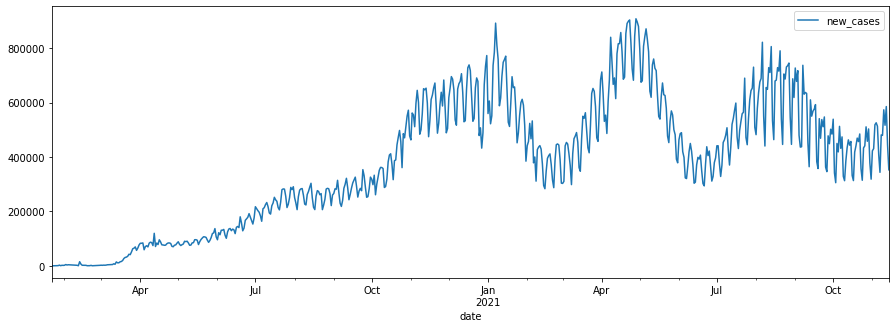

In [ ]:
time_series = df[df.iso_code=='OWID_WRL'][['date','new_cases']].set_index('date')
time_series.plot(figsize=(15,5),logy=False)

Error measure used to evaluate your solution is Root Mean Square Log Error (RMSLE), square-root of 
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error.

In [ ]:
from sklearn.metrics import mean_squared_log_error
def RMSLE(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

Maximum execution time in seconds and days to predict

In [ ]:
import time
max_prediction_time = 3*60
days_to_predict = 7

# My models

<span style="color:red">This is the main section which you should rewrite and expand significanlty providing/documenting your models tried and results with them.</span>

**Here you define your different prediction models. Each model should be in a function that takes the dataframe up to the training_end_date as input and outputs prediction of OWID_WRL new_cases for the following 7 days. The models should only use the data that they get as input! Training, possible hyperparameter optimization, and prediction should be done inside this function. The execution should take no longer than 3 minutes on Google Colab nachine with Tesla**

Give links to the sources of the models and the ideas!

Execution of this section should not take long (no training here, just definition of functions ;).

## 1. A simple persistency model 

Returns the last week as the prediction for the next one. 

In [ ]:
def get_last_week(input_data):
    # simply return the last 7 values of the relevant time series
    intput_time_series = input_data[input_data.iso_code=='OWID_WRL'].new_cases.values
    return intput_time_series[-7:]

## 2. Autoregressive models

Based on https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/.

Documentation: https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AutoReg.html.

A simple univariate autoregressive model with 7 lags.

In [ ]:
!pip install statsmodels --upgrade
from statsmodels.tsa.ar_model import AutoReg

def simple_autoreg(input_data):
    # simple univariate autoregressive model
    # preservind dates as index may be useful to some models
    intput_time_series = input_data[input_data.iso_code=='OWID_WRL'][['date','new_cases']].set_index('date')
    # construct the model and train
    model = AutoReg(intput_time_series, lags =7 ).fit()
    # predict
    prediction = model.predict(start=len(intput_time_series), 
        end=len(intput_time_series)+7-1, dynamic=False)
    return prediction.values

     |████████████████████████████████| 9.8 MB 5.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


The same but with a weekly seasonal component.

In [ ]:
def weekly_autoreg1(input_data):
    # An autoregressive model with weekly seasonal component
    # preservind dates as index may be useful to some models
    intput_time_series = input_data[input_data.iso_code=='OWID_WRL'][['date','new_cases']].set_index('date')
    #intput_time_series = intput_time_series[:-7]
    # construct the model and train
    model = AutoReg(intput_time_series, lags=20, seasonal=True, period=7 ).fit()
    # predict
    prediction = model.predict(start=len(intput_time_series), 
        end=len(intput_time_series)+7-1, dynamic=False)
    return prediction.values

In [ ]:
def weekly_autoreg(input_data):
    # An autoregressive model with weekly seasonal component
    # preservind dates as index may be useful to some models
    intput_time_series = input_data[input_data.iso_code=='OWID_WRL'][['date','new_cases']].set_index('date')
    #intput_time_series = intput_time_series[:-7]
    # construct the model and train
    model = AutoReg(intput_time_series, lags=7, seasonal=True, period=7 ).fit()
    # predict
    prediction = model.predict(start=len(intput_time_series), 
        end=len(intput_time_series)+7-1, dynamic=False)
    return prediction.values

## 3. Mixture models

Mix of sarima_model , prophet_model and get_last_week :

In [ ]:
def combination_of_models(input_data):
    # Mix prophet and weekly autoregression
    prediction1 = prophet_model(input_data)
    prediction2 = get_last_week(input_data)
    return (  prediction1+prediction2) / 2



## 4. LSTM

In [ ]:
#Documentation
#https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
def lstm_model(input_data):
    #Use data until 14 days before as training
    intput_time_series =input_data[input_data.iso_code=='OWID_WRL'][['date','new_cases']].set_index('date')
    x = len(intput_time_series)-14

    train=intput_time_series.iloc[:x]
    test = intput_time_series.iloc[x:]

    ##scaling train and test 
    from sklearn.preprocessing import MinMaxScaler

    sc = MinMaxScaler()
    sc.fit(train) 

    train_scaled = sc.transform(train)
    test_scaled = sc.transform(test)

    ## Use TimeSeriestrain_generator to generate data in sequences.
    from keras.preprocessing.sequence import TimeseriesGenerator

    seq_size = 7  ## number of steps (lookback)
    n_features = 1 ## number of features. This dataset is univariate so it is 1
    train_generator = TimeseriesGenerator(train_scaled, train_scaled, length = seq_size, batch_size=1)

    #Check data shape from generator
    x,y = train_generator[10] #Check train_generator
    #Takes 7 days as x and 8th day as y (for seq_size=7)

    #Also generate test data
    test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)
    #Check data shape from generator
    x,y = test_generator[0]

    from keras.models import Sequential
    from keras.layers import Dense, LSTM, Dropout, Activation

    #Define and fit model
    model = Sequential()
    model.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(seq_size, n_features)))
    model.add(LSTM(150, activation='relu',return_sequences=True))
    model.add(LSTM(150, activation='relu',return_sequences=False))
    model.add(Dense(64))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(train_generator, 
                                      validation_data=test_generator, 
                                      epochs=500, steps_per_epoch=50 , verbose  = 1)
    
    #the code below is to check when validation and training loss are at their lowest  , 200 epochs 
    #seems to be more than enough , i did however set the epochs to 500 to be extra sure.
    """
    #plot the training and validation accuracy and loss at each epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    """

        
    scaled_prediction = [] #Empty list to populate later with predictions

    current_batch = train_scaled[-seq_size:] #Final data points in train 
    current_batch = current_batch.reshape(1, seq_size, n_features) #Reshape

    ## Predict future, beyond test dates
    future = 7 #Days
    for i in range(len(test) + future):
        current_pred = model.predict(current_batch)[0]
        scaled_prediction.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

    ### Inverse transform to before scaling so we get actual numbers
    rescaled_prediction = sc.inverse_transform(scaled_prediction)

    return rescaled_prediction[-7:]

# 5. Prophet 

In [ ]:
#Documentation of the method used 
#https://facebook.github.io/prophet/docs/quick_start.html#python-api
!pip install fbprophet # installing fbprophet lib
def prophet_model(input_data):
    #Preparing the input_data for the model
    input_time_series =input_data[input_data.iso_code=='OWID_WRL'][['date','new_cases']].set_index('date')
    input_time_series = input_time_series[1:]
  
    # importing Prophet
    from fbprophet import Prophet
    import logging

    #logging.getLogger().setLevel(logging.ERROR)

    # changing the column names based on the models guildlines 
    train = input_time_series.reset_index()
    train.columns = ['ds', 'y']
    
    # Define the number of days to predict
    prediction_size = 7
    #the code below was used to find the optimal hyperparameters and then use those to train the model.
    """
    from sklearn.model_selection import ParameterGrid
    params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
    grid = ParameterGrid(params_grid)
    model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
    for p in grid:
        test = pd.DataFrame()
        train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True, 
                         interval_width=0.95)
    """
    #creating an object of the model with the optimal hyperparameters and then fitting to the data 
    train_model =Prophet(changepoint_prior_scale = 0.5,
                        holidays_prior_scale = 0.1,n_changepoints =  100,
                        seasonality_mode =  'additive')
    train_model.fit(train)

    # Make predictions
    future = train_model.make_future_dataframe(periods=prediction_size)
    forecast = train_model.predict(future)
    #the bottom commented code was used to record the error for the model using different hyperparameters
    """
        from sklearn.metrics import mean_squared_error
        MAPE = mean_squared_error(time_series[-7:].values ,forecast.iloc[-7: , -1]  , squared = False)
        model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)
        print(model_parameters)
    """
    return forecast.iloc[-7: , - 1].values

## 6. SARIMA 

In [ ]:
#Documentation of the library and method used . 
#https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
!pip install pmdarima #installing pmdarima lib
def sarima_model(input_data):
    #preparing input_data for training 
    train =input_data[input_data.iso_code=='OWID_WRL'][['date','new_cases']].set_index('date')

    #importing the method
    from pmdarima.arima import auto_arima
    #Tested several seasonal periods , the default m=1 turned out to be the best .
    """ 
    list_of_ms = [1 , 4 , 12 , 52]
    for i in list_of_ms:
        model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True,seasonal=True,m=i)
        model.fit(train)

        forecast = model.predict(n_periods=len(test))
        forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])
        from sklearn.metrics import mean_squared_error
        list_of_acc.append(mean_squared_error(test.values , forecast.values , squared = False))
    """
    #tried out different methods for the solver.The default 'lbfgs' turned out to be the best.
    """
    methods = [  'powell' , 'newton' ,'nm' , 'bfgs' , 'lbfgs' , 'cg' , 'ncg','basinhopping' ]
    errors = []
    for i in methods:
        model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True,seasonal=True,m=52 , method = i  , stepwise  =True)
        model.fit(train)
        forecast = model.predict(n_periods=7)
        error  = RMSLE(np.log(time_series.values[-7:] ), np.log(forecast))
        errors.append(error)
    """
    #fitting the model 
    model = auto_arima(train, trace=True , stepwise  = True, error_action='ignore', suppress_warnings=True,seasonal=True,m=1 )
    model.fit(train)
    
    forecast = model.predict(n_periods=7)
    forecast = np.array(forecast).flatten()
    return forecast

     |████████████████████████████████| 1.4 MB 5.1 MB/s 


# Model validations and results

## Data split for experiments and validation


I use a simple single out of sample validations scheme where the last 7 days of available data are reserved for validation.

I also measure the predict time. This validation scheme is similar to the future final testing (except for the dates).

You should probably expand this to use cross-validation (possibly doing this outside the notebook) for more accurate model selection.

Set the dates:

In [ ]:
from datetime import timedelta
validation_end_date = pd.Timestamp(df.date.max()) # you can change this, e.g. to df.date.max()
days_to_predict = 7
# testing end date will be 2021.11.22 in the end
validation_start_date = validation_end_date - timedelta(days=days_to_predict-1)
training_end_date = validation_end_date - timedelta(days=days_to_predict) # will be 2021.11.15 in the end - the deadline
print((training_end_date, validation_start_date, validation_end_date))
validation_date_range = pd.date_range(validation_start_date, periods=days_to_predict)

(Timestamp('2021-11-07 00:00:00'), Timestamp('2021-11-08 00:00:00'), Timestamp('2021-11-14 00:00:00'))


Generate input and target for validation:

In [ ]:
input_data = df[df.date <= training_end_date]
target_output = df[df.date.isin( validation_date_range ) & (df.iso_code=='OWID_WRL')].new_cases.values
target_output

array([481197., 479447., 573376., 516662., 585343., 444258., 352876.])

## Validate a single model

In [ ]:
import time
model_to_validate = weekly_autoreg1
start_time = time.time()
predicted_time_series = model_to_validate(input_data)
end_time = time.time()
elapsed_time = end_time - start_time

prediction_error = RMSLE(target_output, predicted_time_series)
print('%s prediction error: %.8f, time: %.2fs (max %is)' 
    %(model_to_validate.__name__, prediction_error, elapsed_time, max_prediction_time))  
assert elapsed_time <= max_prediction_time, 'Training is too long!'

weekly_autoreg1 prediction error: 0.06651242, time: 0.05s (max 180s)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:157: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:157: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and NumericIndex with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


Plot real vs. prediction

In [ ]:
import sys

import tensorflow.keras
import tensorflow as tf
import numpy as np
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.7.0
Keras Version: 2.7.0

Python 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
GPU is NOT AVAILABLE


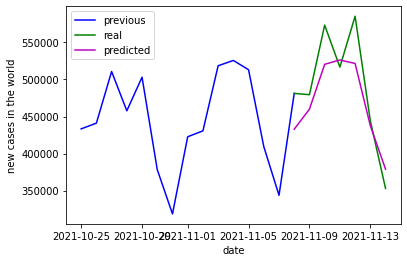

In [ ]:
plt.plot(time_series[-21:-6], 'b')
plt.plot(validation_date_range, target_output, 'g')
plt.plot(validation_date_range, predicted_time_series, 'm')
plt.legend(['previous', 'real', 'predicted'])
plt.xlabel('date')
plt.ylabel('new cases in the world');

## Model validation results

The results here are from a simple out-of-sample validation on dates 2021-10-19 to 2021-10-25, using all the previous data as input.


| Model, variation | Validation RMSLE | Execution time, s |
|-------|---------------|---------------|
| get_last_week  |    0.09525556   | 0.01       |
| simple_autoreg  |    0.11966250   | 0.02       |
| weekly_autoreg, 7 lags |    0.10972075  | 0.03      |
| combination_of_models |**0.07677675**  | 4.91      |
| lstm_model | 0.12027680  | 2372.29        |
| sarima_model |  0.10060392   |   45.13      |
| prophet_model | 0.08793271  |4.94        |


(More on formatting markdown: https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet)

We see that all the models are very fast, the time could be used by more accurate, sophisticated, slower models.

We see that a mixture of prophet and weekly autoregression yielded the best results.

# My best model

I chose the comination_of_models model as my best model . This model combines results from 2 other models , which are the prophet_model and the get_last_week models .


In [ ]:
my_best_model = combination_of_models

# Testing

<span style="color:red">Do not edit beyound this point!</span>

This is a dummy testing routine of `my_best_model`, similar to what will be done after your submission. If your `my_best_model` doesn't work, fix it, not the code here (it will be replaced).

In [ ]:
import numpy as np
import pandas as pd
from datetime import timedelta
import time
from sklearn.metrics import mean_squared_log_error

def RMSLE(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
    
max_prediction_time = 3*60
days_to_predict = 7

url = "owid-covid-data.csv" 
df = pd.read_csv(url, parse_dates=[3])

testing_end_date = pd.Timestamp(2021,10,25) # you can change this, e.g. to df.date.max()
# testing end date will be 2021.11.22 in the end
testing_start_date = testing_end_date - timedelta(days=days_to_predict-1)
testing_input_end_date = testing_end_date - timedelta(days=days_to_predict) # will be 2021.11.15 in the end - the deadline
print((testing_input_end_date, testing_start_date, testing_end_date))
testing_date_range = pd.date_range(testing_start_date, periods=days_to_predict)

test_input_data = df[df.date <= testing_input_end_date]
test_target_output = df[df.date.isin( testing_date_range ) & (df.iso_code=='OWID_WRL')].new_cases.values

start_time = time.time()
test_predicted_output = my_best_model(test_input_data)
end_time = time.time()
elapsed_time = end_time - start_time

prediction_error = RMSLE(test_target_output, test_predicted_output)
print('Test prediction error: %.8f, time: %.2fs (max %is)' 
    %(prediction_error, elapsed_time, max_prediction_time))  
assert elapsed_time <= max_prediction_time, 'Training is too long!'


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(Timestamp('2021-10-18 00:00:00'), Timestamp('2021-10-19 00:00:00'), Timestamp('2021-10-25 00:00:00'))
Test prediction error: 0.14169519, time: 5.74s (max 180s)


## Information on the hardware

Only relavant if execution time is in question: then it is tested on Colab Tesla K80 node.

In [ ]:
import os
osname = os.name
print(osname)
if osname == 'posix':
    f = os.popen('nvidia-smi')
    print(f.read())

    f = os.popen('lscpu')
    print(f.read())
elif osname == 'nt':
    # from https://winaero.com/get-cpu-information-via-command-prompt-in-windows-10/
    f = os.popen('wmic cpu get caption, deviceid, name, numberofcores, maxclockspeed, status')
    print(f.read())

posix
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.


Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_k

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')